In [5]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi

import lina

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

In [2]:
lina.__file__

'/opt/MagAOX/source/lina/lina/__init__.py'

In [3]:
scoobi.__file__

'/opt/MagAOX/source/scoob-interface/scoobi/scoobi.py'

In [2]:
scoobi.home_block(client0)

In [4]:
scoobi.move_block_out(client0)

In [170]:
reload(scoobi)
xc, yc = (4320, 3080)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [6]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')

# Do the normalization

In [9]:
scoobi.move_psf(-50, 0, client0)

In [10]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [11]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [12]:
reload(scoobi)
I.set_fib_atten(30, client)

Set the fiber attenuation to 30.0


INFO:utils:Got semaphore index 1.


40739.92


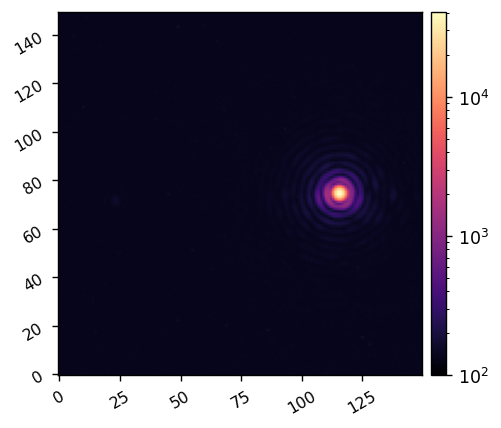

In [13]:
I.Nframes = 100
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [ ]:
cent = np.flip(skimage.measure.centroid(ensure_np_array(mask*arr)))

In [14]:
I.Imax_ref = copy.copy(xp.max(ref_psf))
I.texp_ref = copy.copy(I.texp)
I.att_ref = copy.copy(I.att)
I.gain_ref = copy.copy(I.gain)
print(I.Imax_ref, I.texp_ref, I.att_ref, I.gain_ref  )

40739.92 0.00012 30 120


In [163]:
I.ref_psf_params = {
    'Imax': copy.copy(xp.max(ref_psf)),
    'texp': copy.copy(I.texp), 
    'atten': copy.copy(I.att),
    'gain': copy.copy(I.gain),
}

In [11]:
I.reset_dm()

In [32]:
scoobi.move_psf(-2, 0, client0)

In [25]:
scoobi.move_psf(0, -2, client0)

In [87]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


In [88]:
I.set_zwo_exp_time(0.0003, client0)

Set the ZWO exposure time to 3.00e-04s


In [89]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


# Make a function to adjust bias on the camera
camsci.blacklevel.target

In [90]:
reload(scoobi)
scoobi.move_block_in(client0)

In [96]:
reload(scoobi)
scoobi.move_block_out(client0)

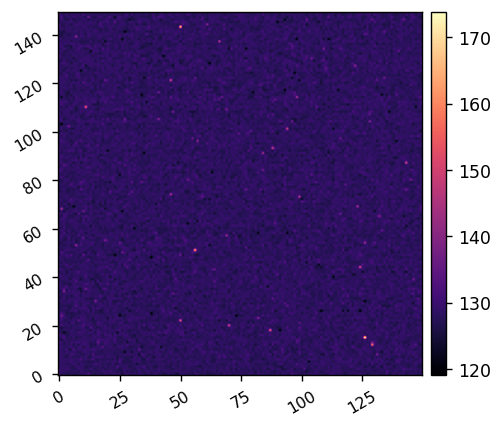

In [94]:
I.Nframes = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

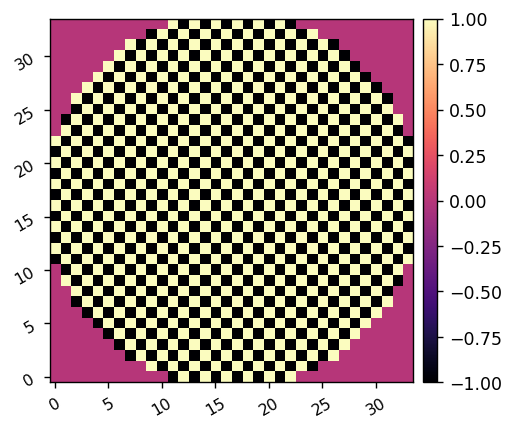

In [97]:
reload(scoobi.utils)
waffle_command = scoobi.utils.create_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

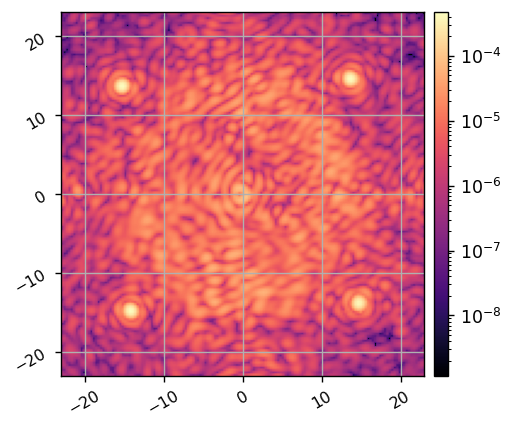

In [98]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamD, grid=True)

Centroids:
 [[ 28.28113116  26.4053963 ]
 [ 24.63016621 119.02134057]
 [118.83495832 122.08319661]
 [122.27551928  29.57590083]
 [ 28.28113116  26.4053963 ]]


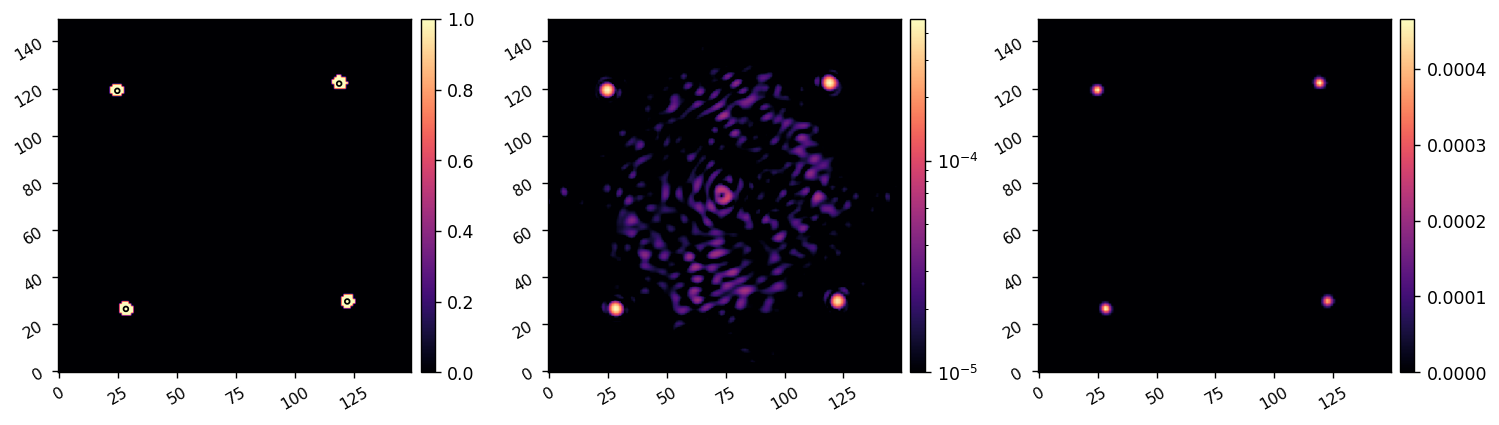

Angle:  87.9547705068114
Measured center in X:  73.53673120698718
Measured center in Y:  74.22177689837935
Required shift in X:  1.0
Required shift in Y:  1.0


In [99]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamD, im_thresh=4e-5, r_thresh=15)

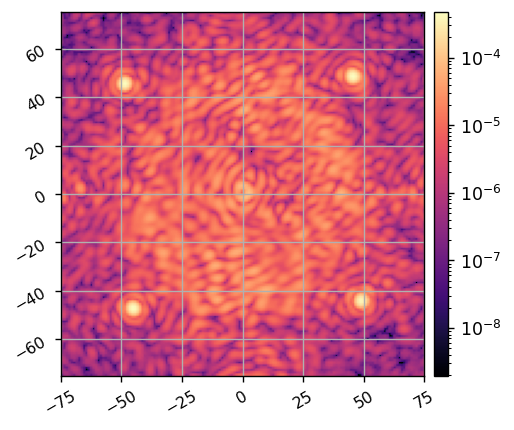

In [100]:
I.Nframes = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift

I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

In [57]:
I.zero_dm()

# Choose modes and probes for iEFC

In [101]:
reload(lina.utils)

iwa = 2.5
owa = 12
rotation = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

1.1136726025335429e-05


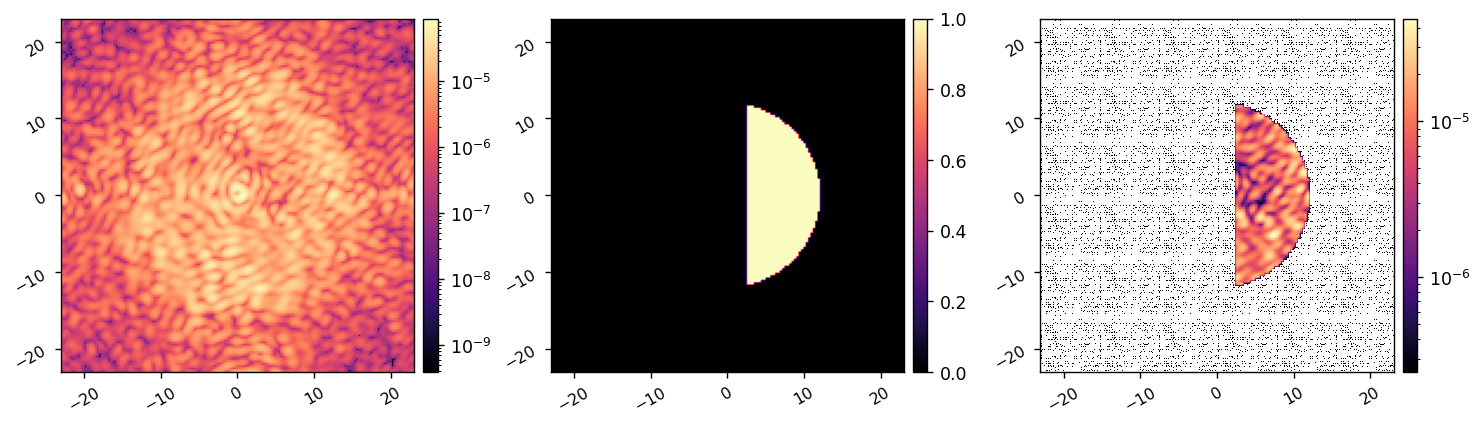

Saved data to:  data/20240910_ref_coro_im.fits


In [102]:
I.zero_dm()
I.Nframes = 10
I.subtract_dark = True
I.return_ni = True

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamD)
lina.utils.save_fits(f'data/{today}_ref_coro_im.fits', ref_coro_im)

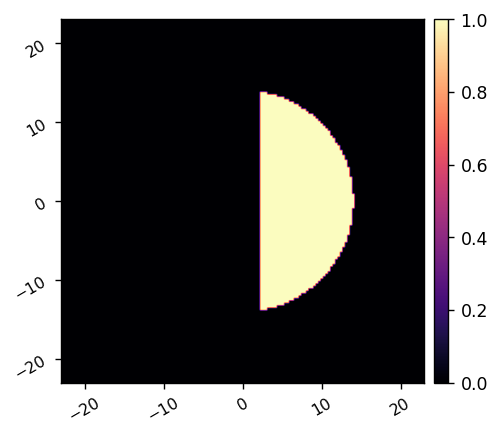

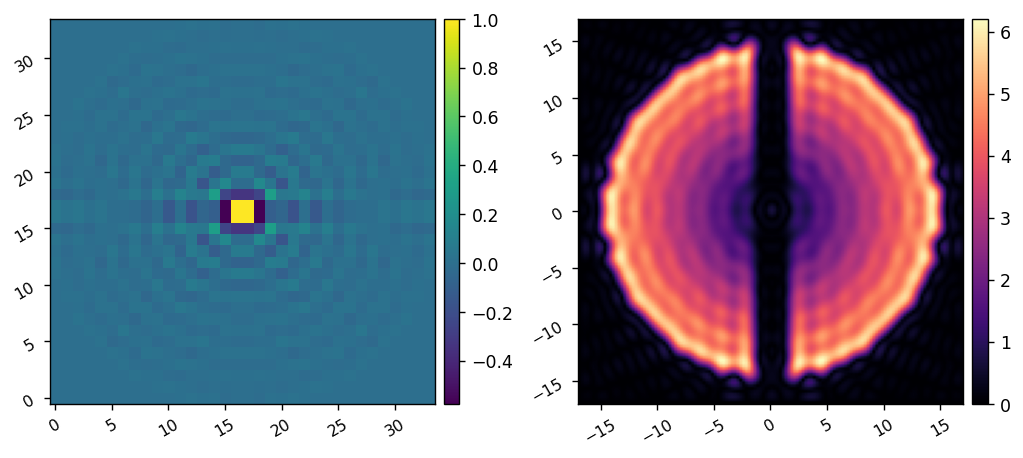

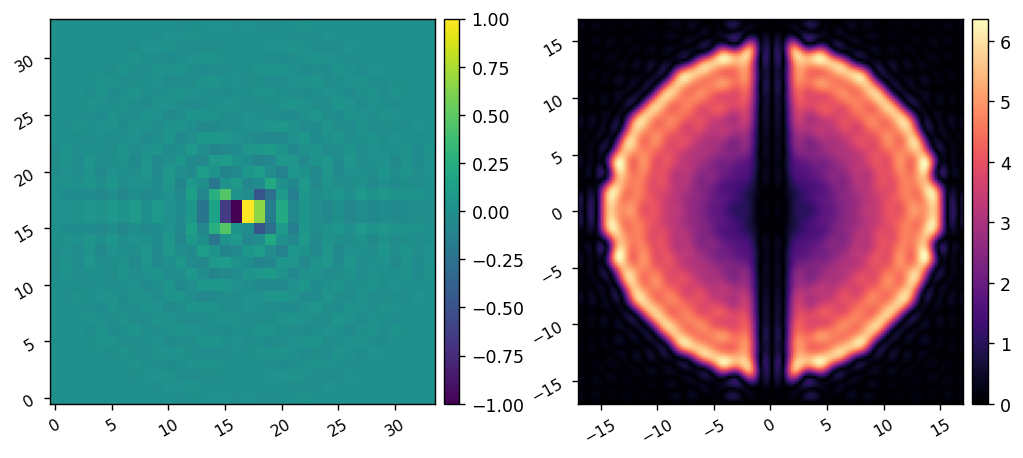

In [103]:
reload(lina.utils)
probe_iwa = 2
probe_owa = 14
probe_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, probe_iwa, probe_owa, edge=probe_iwa)
imshow1(probe_mask, pxscl=I.psf_pixelscale_lamD)
probe_modes = lina.utils.create_fourier_probes(xp.array(I.dm_mask), I.npsf, I.psf_pixelscale_lamD, probe_iwa, probe_owa, 
                                               fourier_sampling=0.75, 
                                                shifts=None, 
                                                nprobes=2,
                                                use_weighting=True, 
                                                plot=True,
                                               )
# for i in range(probe_modes.shape[0]):
#     probe_modes[i] = xp.rot90(probe_modes[i])

In [47]:
reload(lina.utils)

<module 'lina.utils' from '/opt/MagAOX/source/lina/lina/utils.py'>

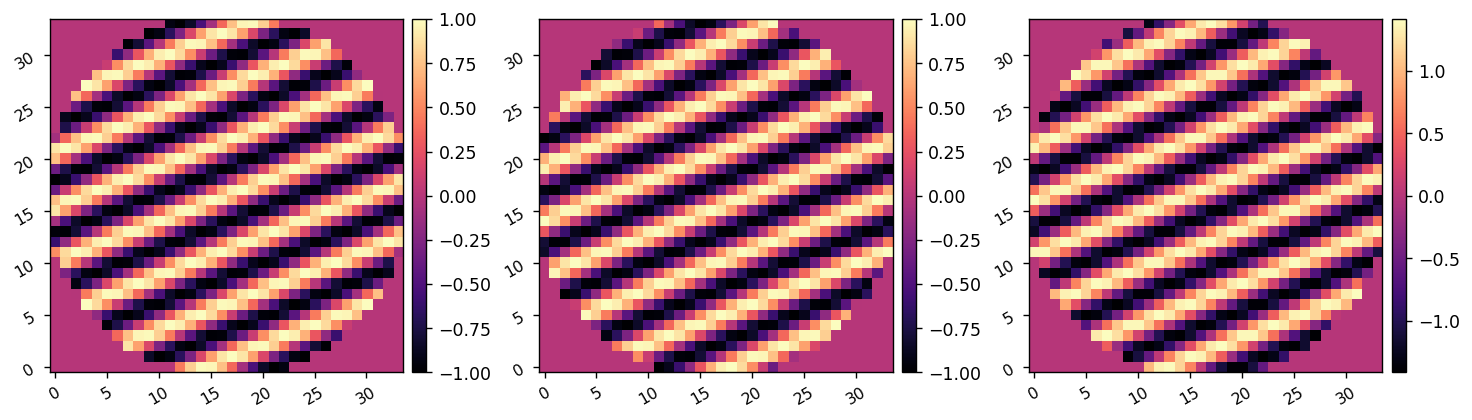

(280, 2) (560, 34, 34)


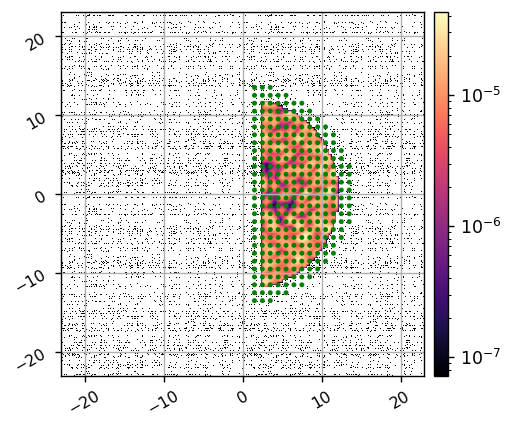

In [182]:
reload(lina.utils)
probe_iwa = 2
probe_owa = 13
fourier_modes, fs = lina.utils.create_fourier_modes(xp.array(I.dm_mask), I.npsf, I.psf_pixelscale_lamD, probe_iwa, probe_owa, 
                                                    fourier_sampling=1,
                                                    return_fs=True,
                                                    # plot=True,
                                                    )
i = 108
imshow3(fourier_modes[i], fourier_modes[i+1], fourier_modes[i]-fourier_modes[i+1])
print(fs.shape, fourier_modes.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.2
    patches.append(Circle(center, radius, fill=True, color='g'))
    
imshow1(ref_coro_im*control_mask, lognorm=True, pxscl=I.psf_pixelscale_lamD, patches=patches, grid=True)

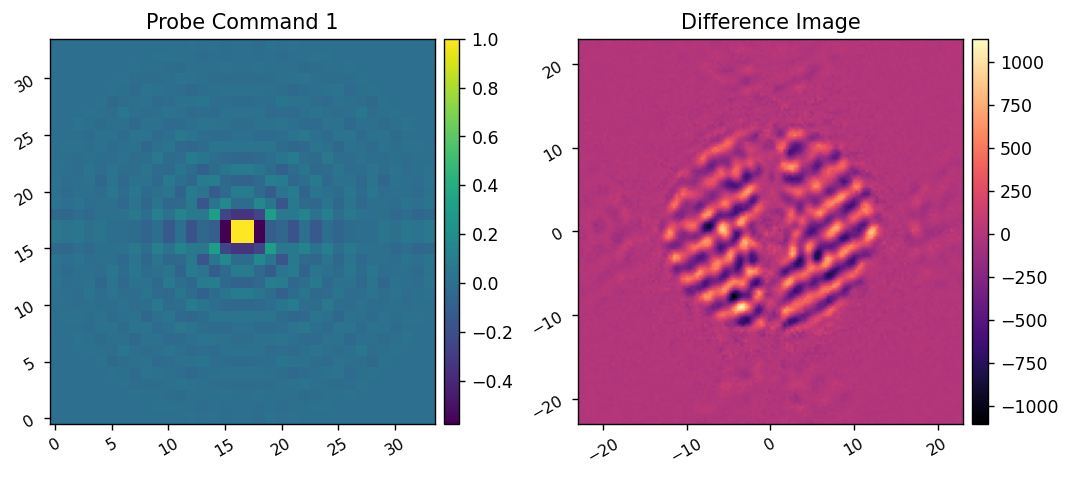

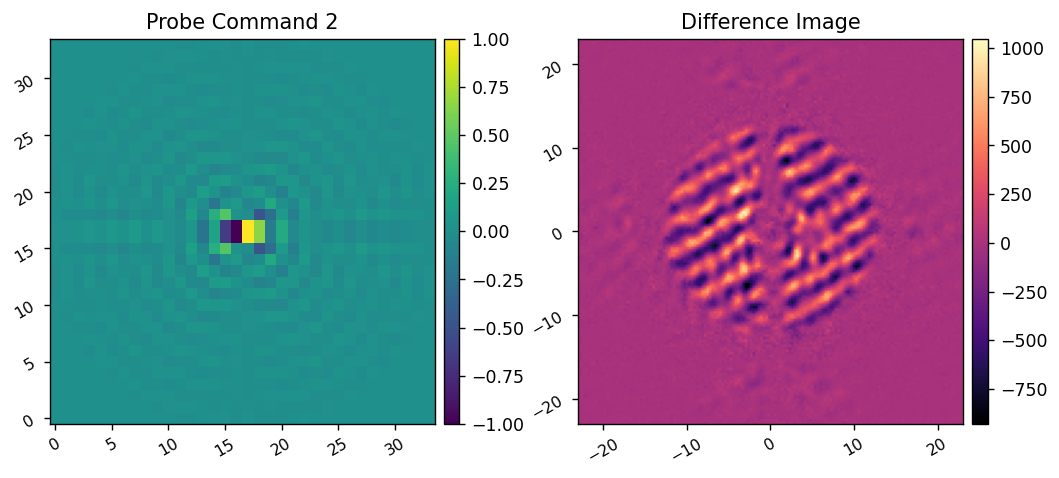

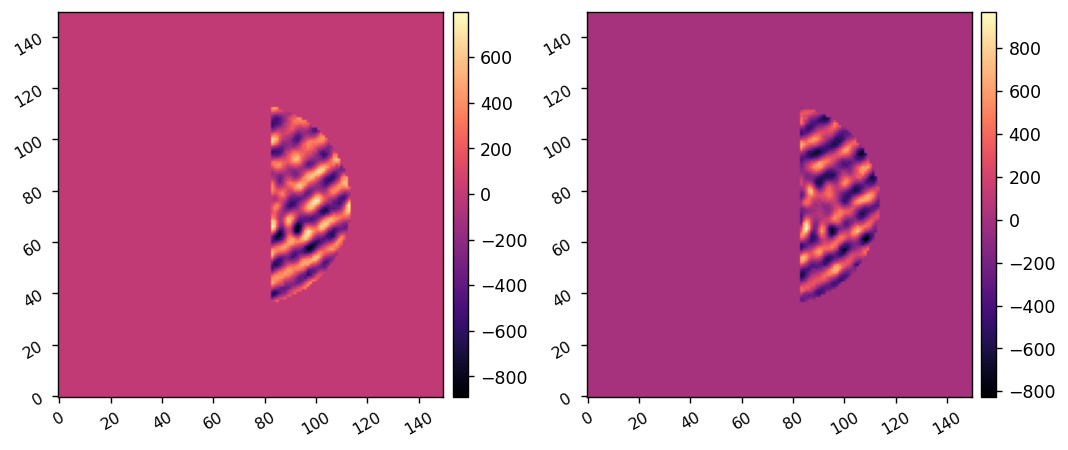

In [104]:
reload(lina.iefc)

I.Nframes = 10
I.subtract_dark = False
I.return_ni = True
diff_ims = lina.iefc.take_measurement(I, probe_modes, 5e-9, plot=True)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

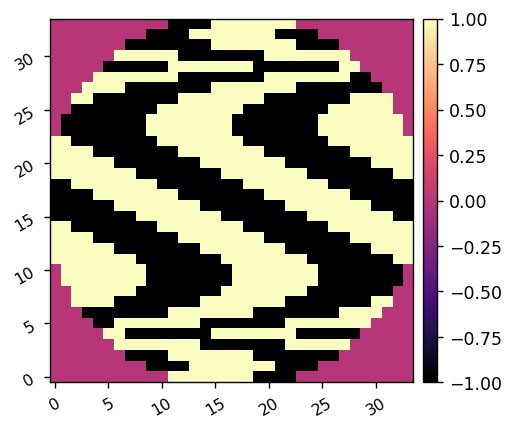

In [105]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(I.dm_mask))
imshow1(calib_modes[8])


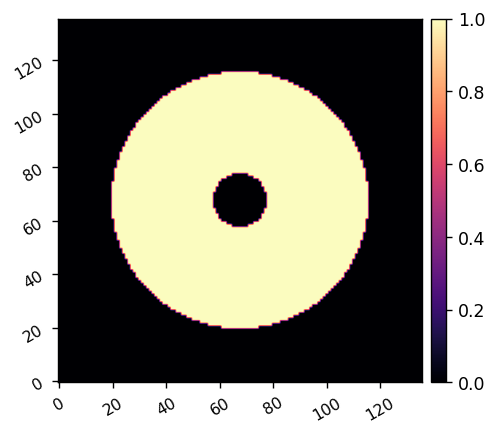

(1024,)
[1.19805206 1.93675952 1.50992211 1.58041594]


In [111]:
reload(scoobi.utils)
oversamp = 4

had_modes = xp.array(calib_modes)
ft_modes = []
for i in range(calib_modes.shape[0]//2):
    had_mode = had_modes[i,:I.Nact**2].reshape(I.Nact, I.Nact)
    ft_modes.append(xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(scoobi.utils.pad_or_crop(had_mode, I.Nact*oversamp)))))
mode_freqs = xp.abs(xp.array(ft_modes))

mode_freq_mask_pxscl = 1/oversamp
x = (xp.linspace(-I.Nact*oversamp//2, I.Nact*oversamp//2-1, I.Nact*oversamp) + 1/2)*mode_freq_mask_pxscl
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2+y**2)
mode_freq_mask = (r>2.5)*(r<12)
imshow1(mode_freq_mask)

sum_vals = []
max_vals = []
for i in range(calib_modes.shape[0]//2):
    sum_vals.append(xp.sum(mode_freqs[i, mode_freq_mask]))
    max_vals.append(xp.max(mode_freqs[i, mode_freq_mask]**2))

biggest_sum = xp.max(xp.array(sum_vals))
biggest_max = xp.max(xp.array(max_vals))

scale_factors = []
for i in range(calib_modes.shape[0]//2):
    scale_factors.append((biggest_max/max_vals[i])**(1/6))
    # scale_factors.append((biggest_sum/sum_vals[i])**(1/2))
scale_factors = ensure_np_array(xp.array(scale_factors))
# scale_factors[scale_factors>2] = 2
# scale_factors[scale_factors<1/2] = 1/2

scale_factors = np.concatenate([scale_factors,scale_factors])
print(scale_factors.shape)

scale_thresh = 4
scale_factors[scale_factors>scale_thresh] = scale_thresh
print(scale_factors[8:12])

In [110]:
1.1**(1/4)

1.0241136890844451

In [112]:
I.zero_dm()

In [113]:
reload(lina.iefc)
I.zero_dm()

probe_amp = 5e-9
calib_amp = 2.5e-9

I.Nframes = 10
I.return_ni = True
I.subtract_dark = False
I.dm_delay = I.texp * 3
print(I.dm_delay)

time.sleep(2)
response_matrix, response_cube = lina.iefc.calibrate(I, control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, scale_factors=scale_factors, 
                                                    #  calib_amp, calib_modes[100:110], 
                                                    #  scale_factors=scale_factors[100:110], 
                                                    #  calib_amp, calib_modes[8:12], 
                                                    #  scale_factors=scale_factors[8:12], 
                                                     return_all=True,
                                                     )

0.0009
Calibrating iEFC...
	Calibrated mode 1024/1024 in 576.304s
Calibration complete.


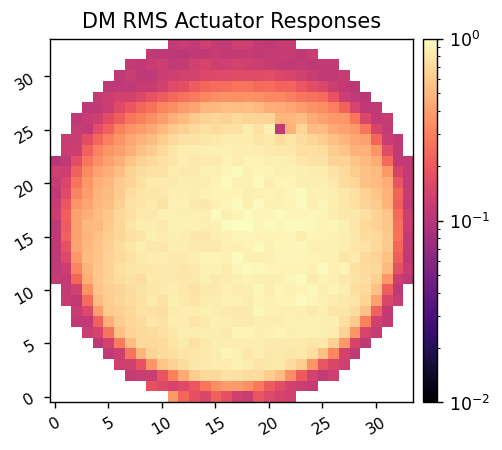

In [114]:
dm_response_map = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes.reshape(1024, -1))), axis=0))
dm_response_map = dm_response_map.reshape(I.Nact,I.Nact) / xp.max(dm_response_map)
imshow1(dm_response_map, 'DM RMS Actuator Responses', lognorm=True, vmin=1e-2)

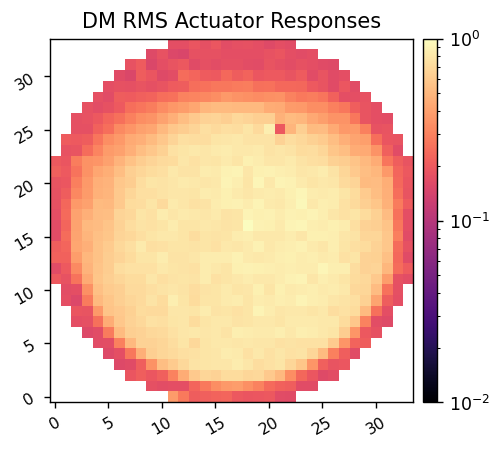

In [61]:
dm_response_map = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes.reshape(1024, -1))), axis=0))
dm_response_map = dm_response_map.reshape(I.Nact,I.Nact) / xp.max(dm_response_map)
imshow1(dm_response_map, 'DM RMS Actuator Responses', lognorm=True, vmin=1e-2)

In [115]:
lina.utils.save_fits(f'data/{today}_iefc_hadamard_jac.fits', response_matrix)
lina.utils.save_fits(f'data/{today}_iefc_hadamard_jac_cube.fits', response_cube)
lina.utils.save_fits(f'data/{today}_iefc_probes.fits', probe_modes)

# lina.utils.save_fits('../data/iefc_fourier_jac_20240806.fits', response_matrix)
# lina.utils.save_fits('../data/iefc_fourier_jac_cube_20240806.fits', response_cube)

Saved data to:  data/20240910_iefc_hadamard_jac.fits
Saved data to:  data/20240910_iefc_hadamard_jac_cube.fits
Saved data to:  data/20240910_iefc_probes.fits


In [116]:
I.zero_dm()
all_ims = []
all_commands = []

In [79]:
I.set_dm(all_commands[-1])

0.06
Running iEFC...
	Closed-loop iteration 25 / 27
(1024, 1156) (1024,)


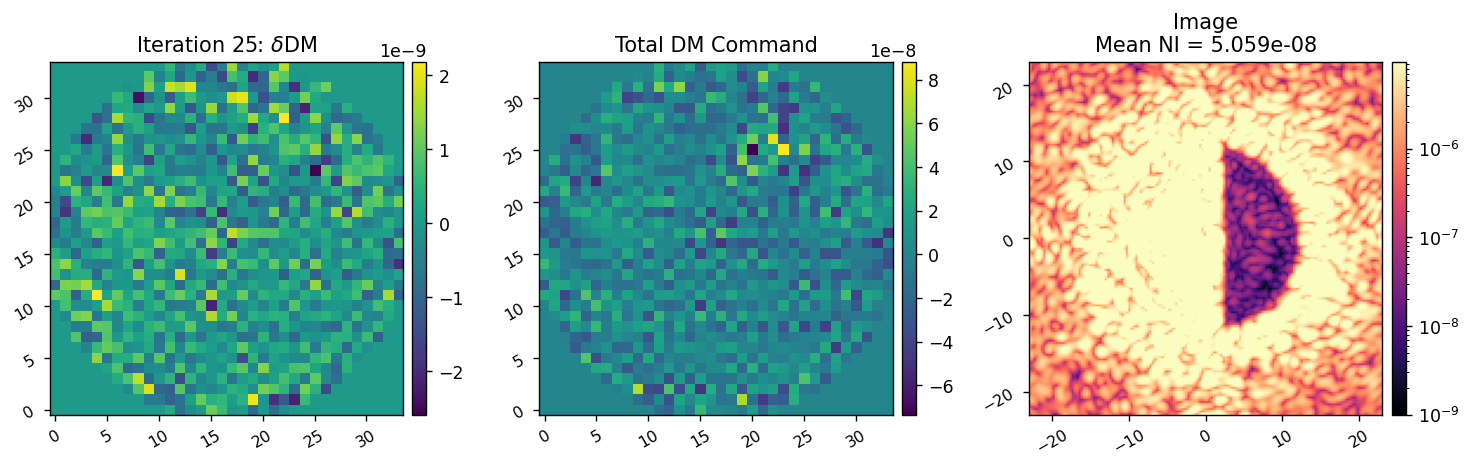

	Closed-loop iteration 26 / 27
(1024, 1156) (1024,)


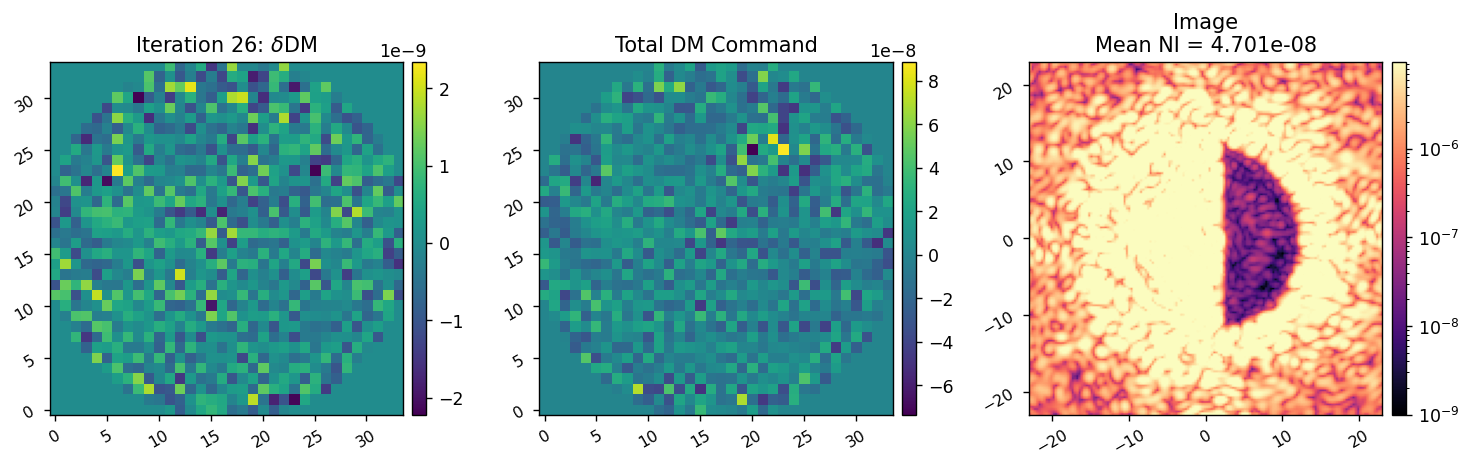

	Closed-loop iteration 27 / 27
(1024, 1156) (1024,)


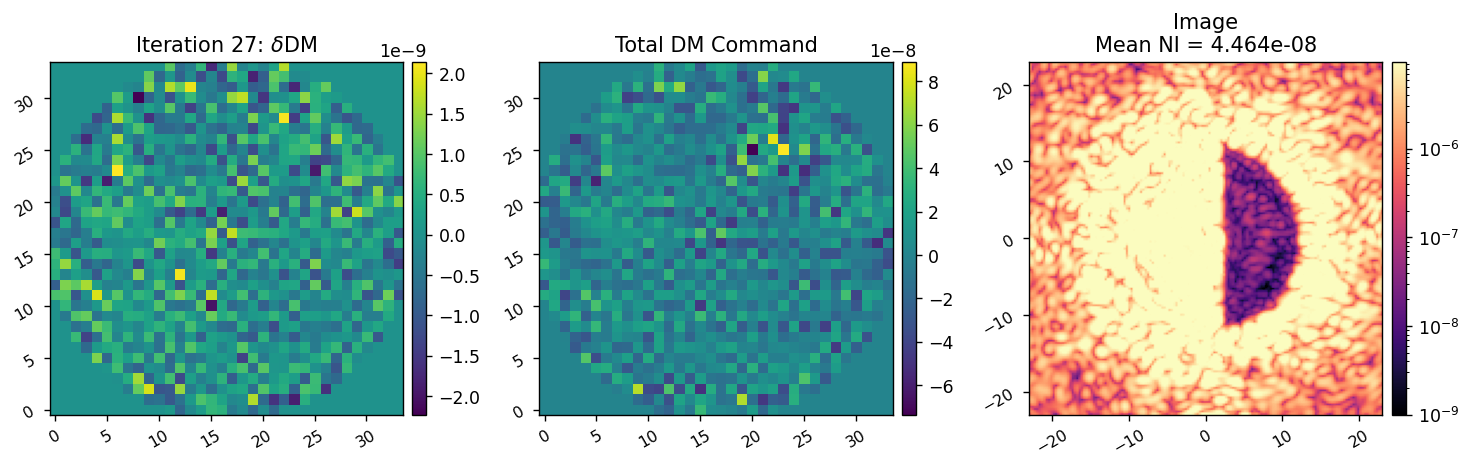

Closed loop for given control matrix completed in 7.414s.


In [136]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
# cm = lina.utils.beta_reg(response_matrix, -3.5)
# cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
probe_amp = 4e-9
# probe_amp = 3e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
probe_amp = 1e-9

I.Nframes = 10
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

all_ims, all_commands = lina.iefc.run(I,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims,
                                        all_commands=all_commands,
                                        )

In [127]:
I.set_zwo_exp_time(0.02, client0, delay=1)
I.set_zwo_gain(120, client0)
I.Nframes = 10

Set the ZWO exposure time to 2.00e-02s
Set the ZWO gain setting to 120.0


In [128]:
reload(scoobi)
scoobi.move_block_in(client0)

In [130]:
reload(scoobi)
scoobi.move_block_out(client0)

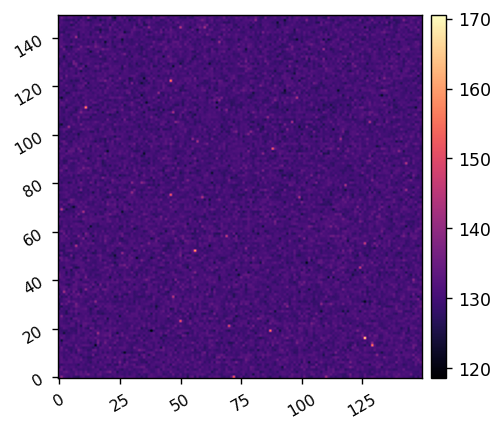

In [129]:
I.Nframes = 50
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

4.515280613673951e-08


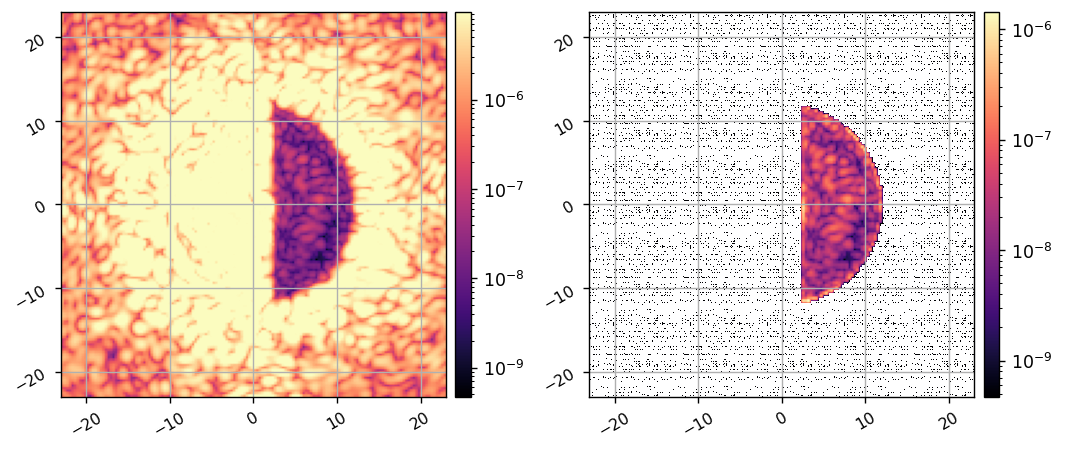

In [137]:
I.Nframes = 10
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im, grid=True, lognorm=True, pxscl=I.psf_pixelscale_lamD)

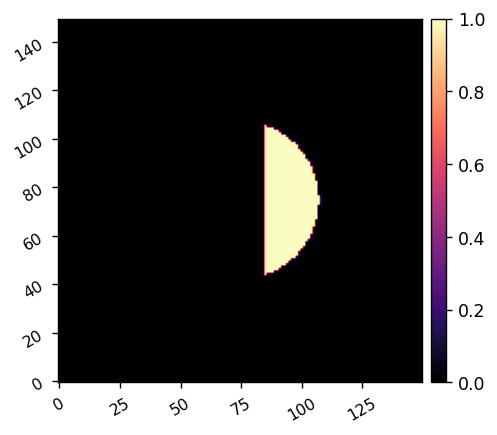

In [138]:
new_iwa = 3
new_owa = 10
new_control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, new_iwa, new_owa, edge=new_iwa, rotation=rotation)
imshow1(new_control_mask)

In [139]:
new_response_matrix = response_cube[:, :, new_control_mask.ravel()].reshape(1024, -1).T
new_response_matrix.shape

(2044, 1024)

0.15000000000000002
Running iEFC...
	Closed-loop iteration 61 / 63
(1024, 1156) (1024,)


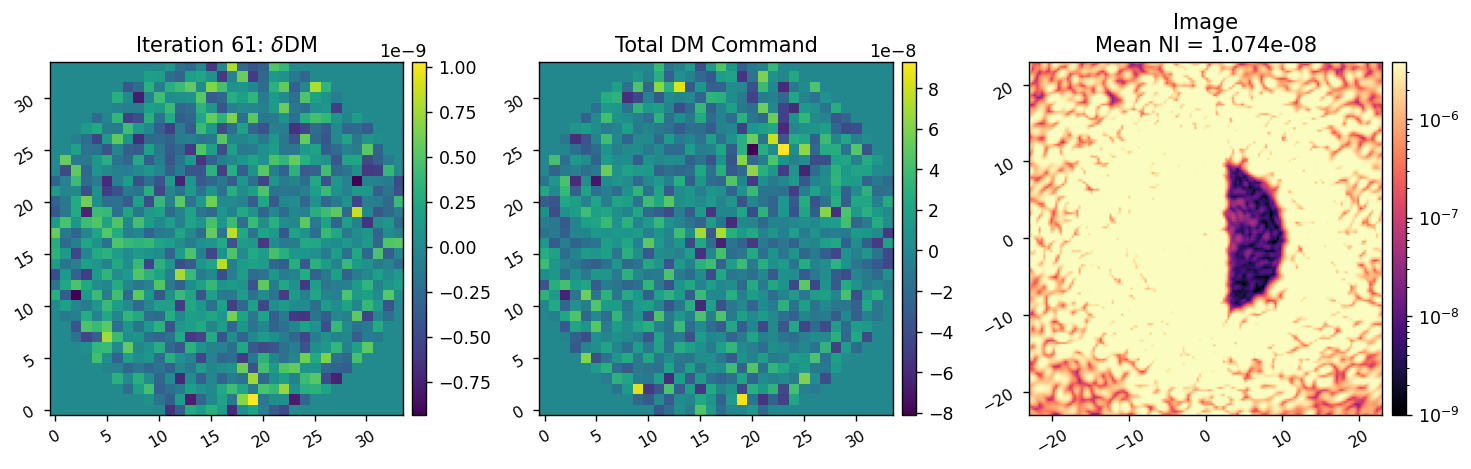

	Closed-loop iteration 62 / 63
(1024, 1156) (1024,)


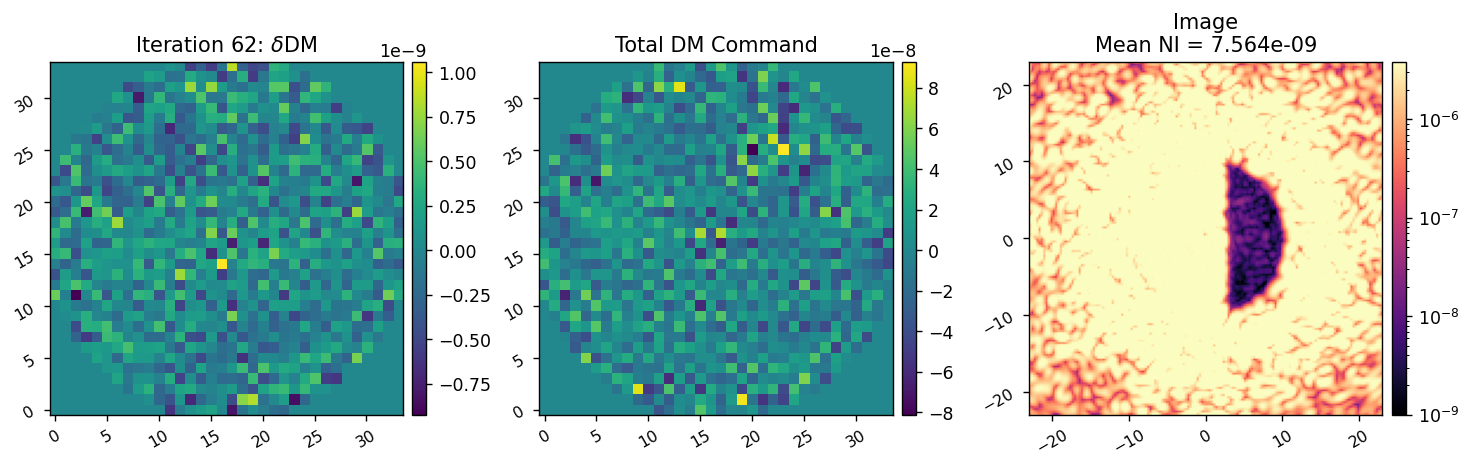

	Closed-loop iteration 63 / 63
(1024, 1156) (1024,)


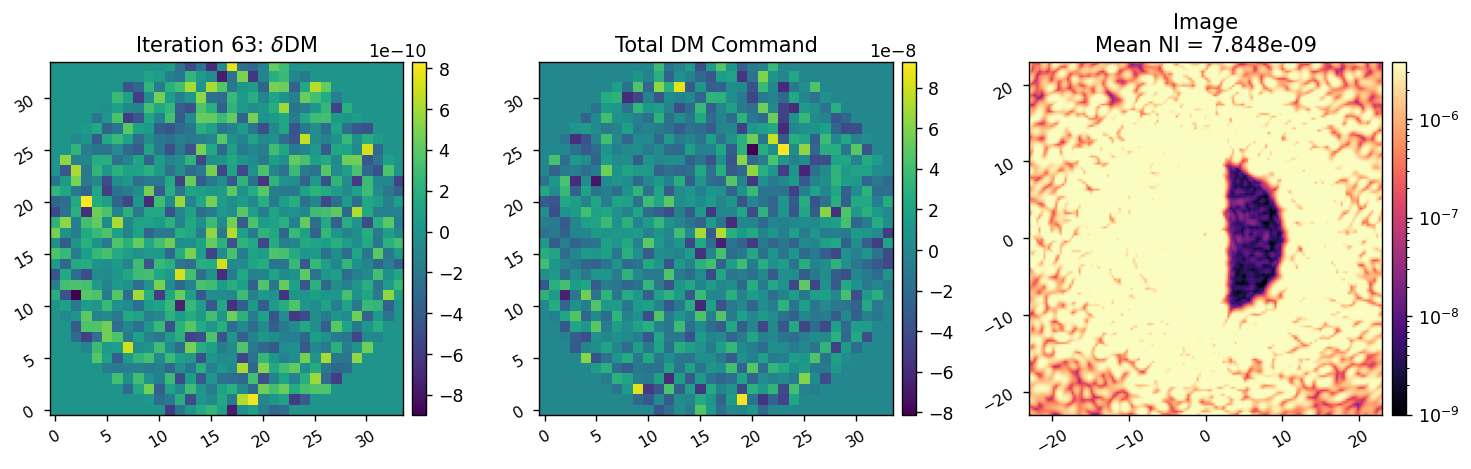

Closed loop for given control matrix completed in 13.959s.


In [165]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(new_response_matrix, -2.5)
# cm = lina.utils.beta_reg(new_response_matrix, -3.5)
# cm = lina.utils.beta_reg(new_response_matrix, -5)

probe_amp = 5e-9
# probe_amp = 4e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
probe_amp = 1e-9
probe_amp = 0.75e-9
# probe_amp = 0.5e-9

I.Nframes = 10
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

all_ims, all_commands = lina.iefc.run(I,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        new_control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )

In [157]:
lina.utils.save_fits(f'data/{today}_iefc_hadamard_ims.fits', xp.array(all_ims))
lina.utils.save_fits(f'data/{today}_iefc_hadamard_commands.fits', xp.array(all_commands))
lina.utils.save_fits(f'data/{today}_iefc_control_mask_1.fits', control_mask.astype(int))
lina.utils.save_fits(f'data/{today}_iefc_control_mask_2.fits', new_control_mask.astype(int))


Saved data to:  data/20240910_iefc_hadamard_ims.fits
Saved data to:  data/20240910_iefc_hadamard_commands.fits
Saved data to:  data/20240910_iefc_control_mask_1.fits
Saved data to:  data/20240910_iefc_control_mask_2.fits


In [142]:
I.set_zwo_exp_time(0.05, client0, delay=1)
I.set_zwo_gain(120, client0)
I.Nframes = 10

Set the ZWO exposure time to 5.00e-02s
Set the ZWO gain setting to 120.0


In [166]:
reload(scoobi)
scoobi.move_block_in(client0)

In [167]:
reload(scoobi)
scoobi.move_block_out(client0)

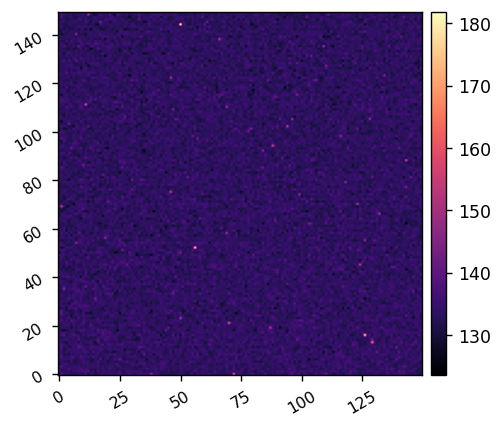

In [144]:
I.Nframes = 50
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

7.531472642925912e-09


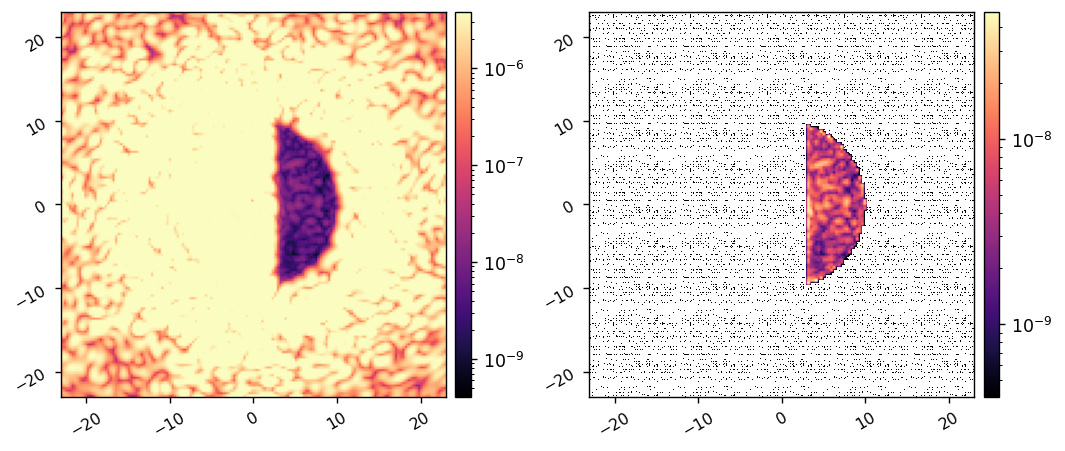

In [168]:
I.Nframes = 10
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[new_control_mask]))
imshow2(coro_im, new_control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

In [277]:
I.zero_dm( )
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


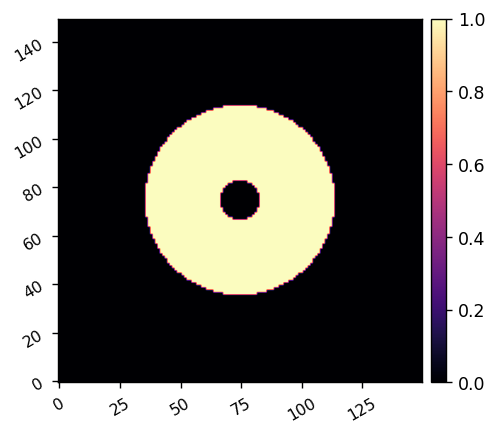

In [74]:
new_iwa = 2.5
new_owa = 12
annular_control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, new_iwa, new_owa)
imshow1(annular_control_mask)

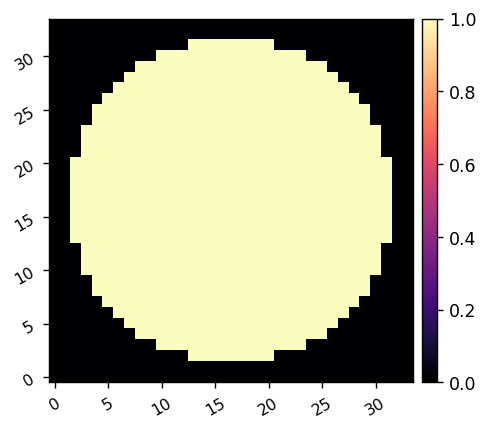

In [94]:
imshow1(I.dm_pupil_mask)

In [98]:
type(I.dm_pupil_mask), type(response_mask)

(numpy.ndarray, cupy.ndarray)

727


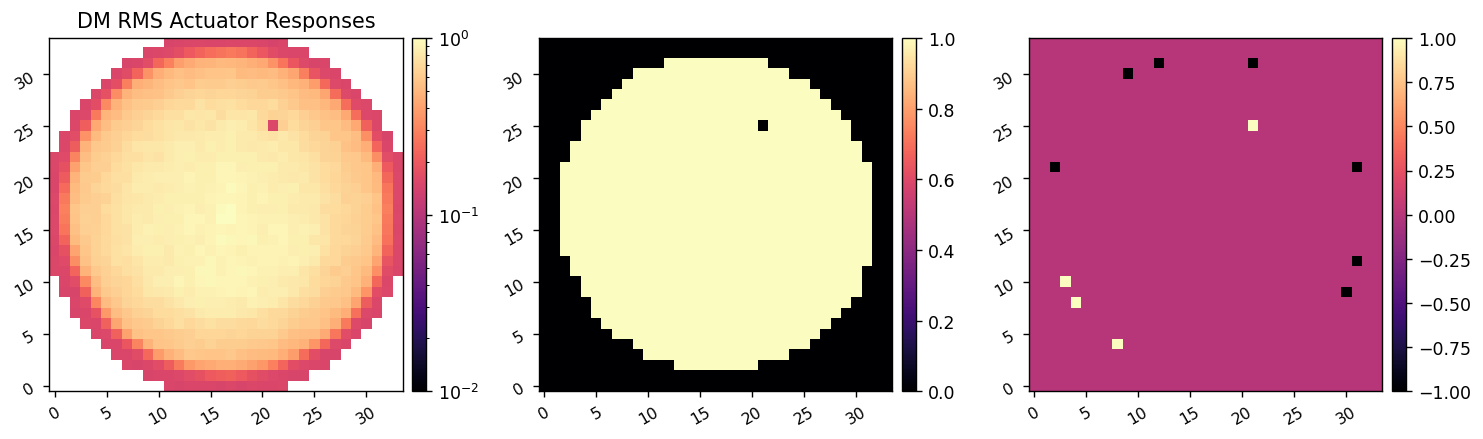

In [104]:
annular_response_matrix = response_cube[:, :, annular_control_mask.ravel()].reshape(1024, -1).T
full_response_map = xp.sqrt(xp.mean(xp.square(annular_response_matrix.dot(calib_modes)), axis=0))
full_response_map = full_response_map.reshape(I.Nact, I.Nact) / xp.max(full_response_map)
response_mask = full_response_map>3.5e-1
print(response_mask.sum())
imshow3(full_response_map, response_mask, I.dm_pupil_mask.astype(float) - ensure_np_array(response_mask), 
        'DM RMS Actuator Responses', lognorm1=True, vmin1=1e-2)

In [99]:
restart_clients()

INFO:purepyindi2.transports:Connected to localhost:7624


# Monitor the dark hole

In [162]:
reload(scoobi)
from pathlib import Path

duration = 1800
duration = 10
I.Nframes = 20

# time.sleep(5)
scoobi.stream_scicam(I, 
                     duration=duration, 
                     control_mask=new_control_mask, 
                     plot=True, 
                     clear=True, 
                     save_data_to=Path(f'camsci-streams/{today}_ims_without_llowfsc.fits'),
                     )

Saved data to:  camsci-streams/20240910_ims_without_llowfsc.fits


In [169]:
I.zero_dm()

In [163]:
type(I.snap())

cupy.ndarray